In [8]:
# Set up data getting functions for analysis
import os
os.chdir('C:\\\\Users\\\\rober\\\\PycharmProjects\\\\crusher\\\\src')
from utils.helper_functions.data_loading import get_odds_data, get_match_odds_data
from crusher.runner import RunnerCodeEnum as RCEnum
from crusher.market_type import MarketTypeCodeEnum as MTCEnum
from crusher.division import DivisionCodeEnum as DCEnum
from utils.db.database_manager import dbm
from crusher.item_freq_type import ItemFreqTypeCodeEnum as IFTCEnum
from utils.helper_functions import calculation as calc
from matplotlib import pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
from utils.db.database_manager import dbm
from utils.helper_functions import preprocessing as pr
from orm.orm import ExchangeOddsSeries
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from utils.helper_functions import calculation as calc
import numpy as np
from utils.helper_functions.backtest import BacktestStrategy
from models.correct_score_0_0.simple_strategies import naive_high_odds_grabber_by_ticks, naive_high_odds_grabber_by_percentage


def get_nil_nil_odds_df(session):
    df = get_odds_data(session=session,
                       runner=RCEnum.SCORE_0_0,
                       divisions=[DCEnum.PREMIER_LEAGUE, DCEnum.CHAMPIONSHIP],
                       item_freq_type_code=IFTCEnum.MINUTE,
                       in_play=False)
    df = pr.add_event_uid_to_df(df)
    df = pr.drop_outlier_series_by_std(df)
    df = pr.drop_series_by_n_data_points(df, 40)
    return df

def get_match_odds_df(session):
    df_match_odds = get_match_odds_data(session=session,
                                      divisions=[DCEnum.PREMIER_LEAGUE],
                                      item_freq_type_code=IFTCEnum.MINUTE,
                                      in_play=False)
    df_match_odds = pr.drop_series_by_n_data_points(df_match_odds, 40)
    df_match_odds = pr.drop_outlier_series_by_std(df_match_odds, 3, value_col='team_a')
    df_match_odds = pr.add_event_uid_to_df(df_match_odds)
    df_match_odds['ho_ao_ratio'] = abs(df_match_odds['team_a'] / df_match_odds['team_b'])
    
    return df_match_odds

        
def get_joined_match_score_odds_df(session):
    df_score = get_nil_nil_odds_df(session)
    df_match = get_match_odds_df(session)
    df_score = df_score.drop('series_uid', axis=1)
    df_match = df_match.drop('series_uid', axis=1)

    df = pd.DataFrame(columns=['score_odds', 'ho_ao_ratio', 'event_uid'])
    for event_uid in df_match['event_uid'].unique():
        if event_uid not in df_score['event_uid'].unique():
            continue
        sub_match_df = df_match[df_match['event_uid'] == event_uid]
        sub_match_df = sub_match_df[['event_uid', 'ho_ao_ratio', 'published_datetime']]
        sub_match_df = sub_match_df.set_index('published_datetime')

        sub_score_df = df_score[df_score['event_uid'] == event_uid]
        sub_score_df = sub_score_df[['ltp', 'published_datetime']]
        sub_score_df = sub_score_df.set_index('published_datetime')

        joined_df = sub_score_df.join(sub_match_df, how='outer')
        joined_df[['ltp', 'ho_ao_ratio']] = joined_df[['ltp', 'ho_ao_ratio']].fillna(method='ffill')
        joined_df[['ltp', 'ho_ao_ratio']] = joined_df[['ltp', 'ho_ao_ratio']].fillna(method='bfill')
        joined_df['event_uid'] = event_uid
        joined_df = joined_df.rename(columns={'ltp': 'score_odds'})
        df = pd.concat([df, joined_df])

    return df

### Volitility
Examining volitility of the prices and how it varies by mean price.

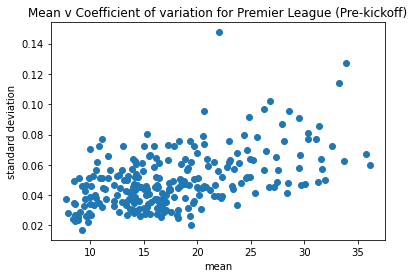

In [5]:
with dbm.get_managed_session() as session:
    df = get_nil_nil_odds_df(session)
value_counts = df['series_uid'].value_counts().reset_index().rename(columns={'series_uid': 'item_count',
                                                                             'index': 'series_uid'})
means = df.groupby('series_uid').mean().rename(columns={'ltp': 'series_mean'}).reset_index()
std_deviations = df.groupby('series_uid').std().rename(columns={'ltp': 'series_std_dev'}).reset_index()
comparison_df = pd.merge(means, std_deviations, on='series_uid')
comparison_df = pd.merge(comparison_df, value_counts, on='series_uid')
comparison_df['coefficients_of_variation'] = comparison_df['series_std_dev'] / comparison_df['series_mean']
plt.scatter(comparison_df['series_mean'], comparison_df['coefficients_of_variation'])
plt.ylabel('standard deviation')
plt.xlabel('mean')
plt.title("Mean v Coefficient of variation for Premier League (Pre-kickoff)")
plt.show()


### Relationship between 0-0 and match odds markets 

[[-0.38287668]]
[18.03061927]
Correlation between match odds difference and 0-0 odds is:
[[ 1.         -0.11899958]
 [-0.11899958  1.        ]]
Correlation between match odds difference and 0-0 odds is:
[[ 1.         -0.11899958]
 [-0.11899958  1.        ]]


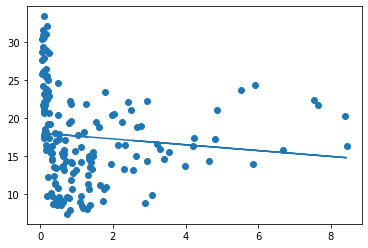

In [9]:
# Get match odds data
with dbm.get_managed_session() as session:
    df = get_joined_match_score_odds_df(session)
match_odds_diff_means = df.groupby('event_uid')['ho_ao_ratio'].mean()
score_odds_means = df.groupby('event_uid')['score_odds'].mean()
comparison_df = pd.DataFrame(match_odds_diff_means)
comparison_df['score_odds'] = score_odds_means
lr = LinearRegression()
lr.fit(comparison_df[['ho_ao_ratio']], comparison_df[['score_odds']])

plt.scatter(comparison_df['ho_ao_ratio'], comparison_df['score_odds'])
plt.plot(comparison_df['ho_ao_ratio'], lr.predict(comparison_df[['ho_ao_ratio']]))
plt.xlabel = 'ho_ao_ratio'
plt.ylabel = 'score odds'
print(lr.coef_)
print(lr.intercept_)

print('Correlation between match odds difference and 0-0 odds is:')
print(np.corrcoef(df['ho_ao_ratio'], df['score_odds']))
print('Correlation between match odds difference and 0-0 odds is:')
print(np.corrcoef(df['ho_ao_ratio'], df['score_odds']))


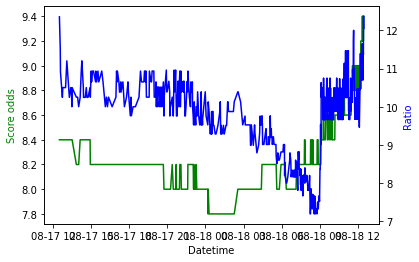

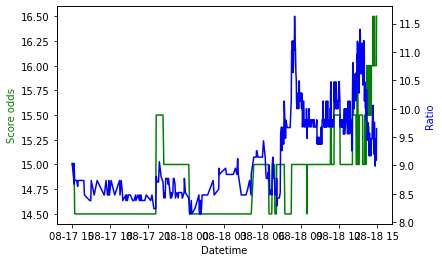

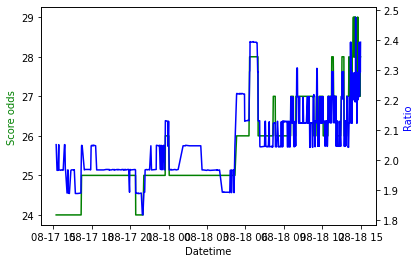

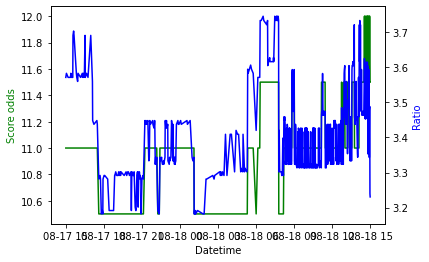

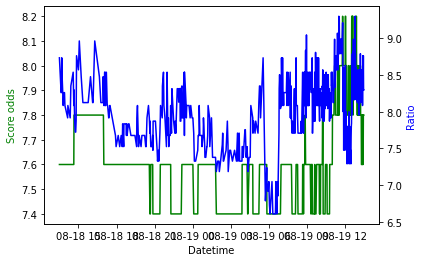

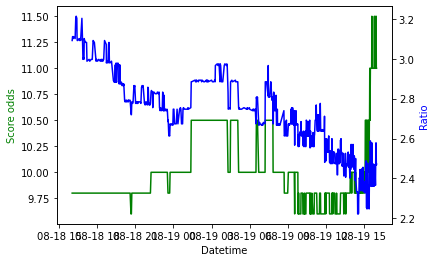

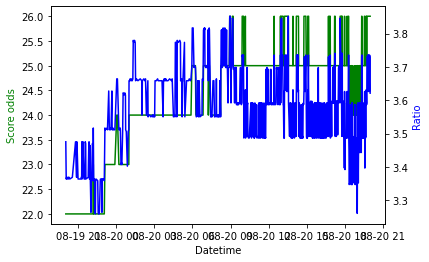

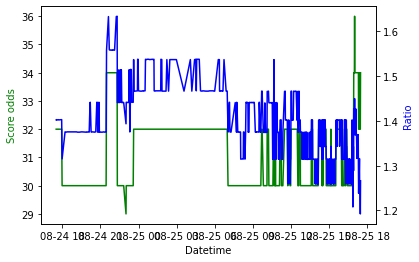

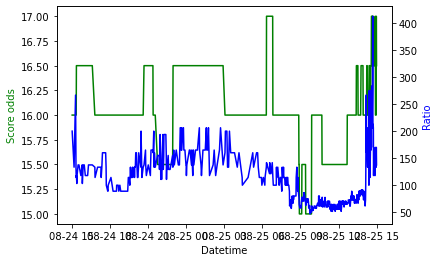

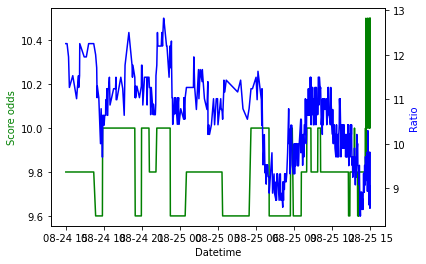

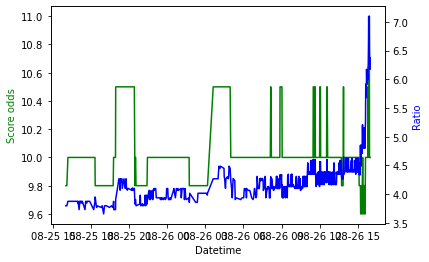

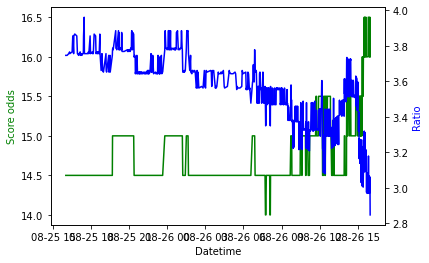

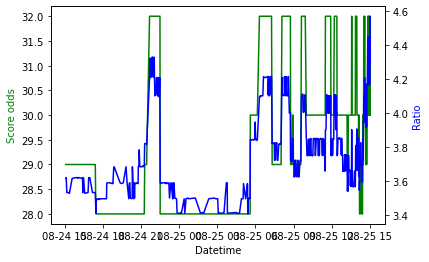

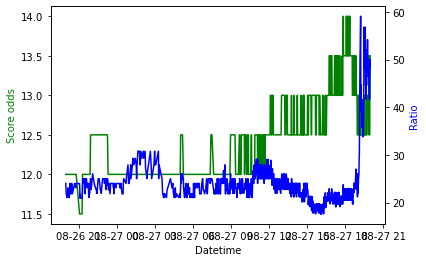

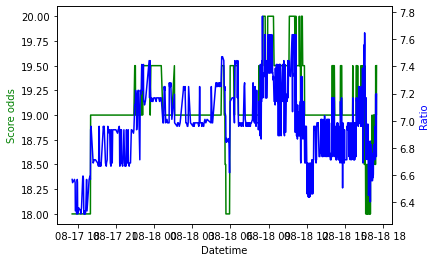

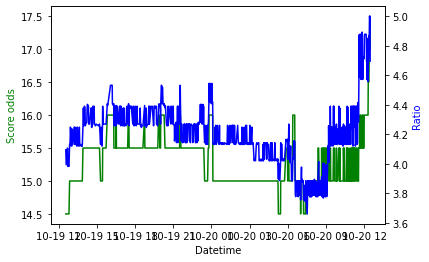

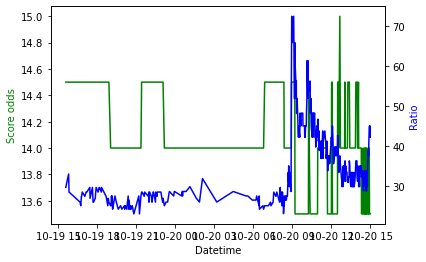

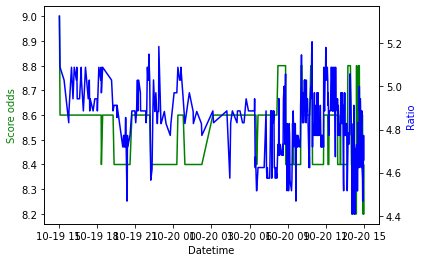

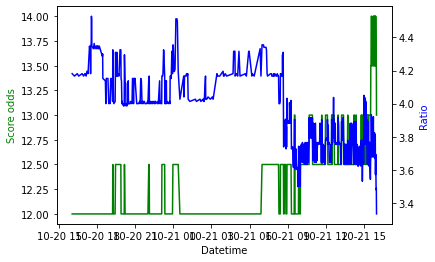

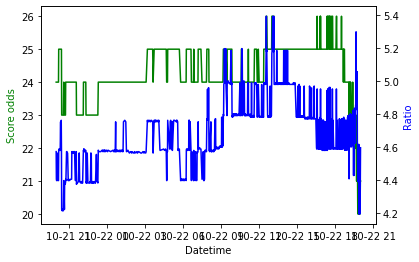

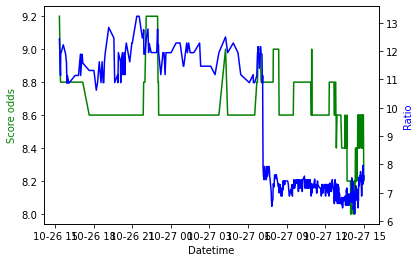

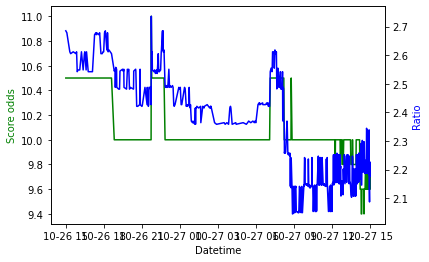

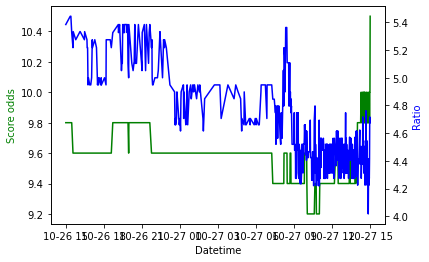

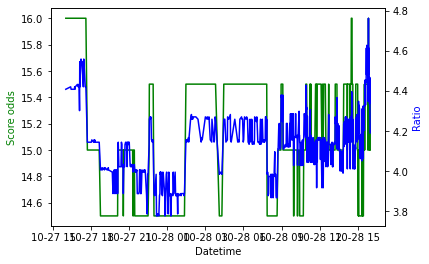

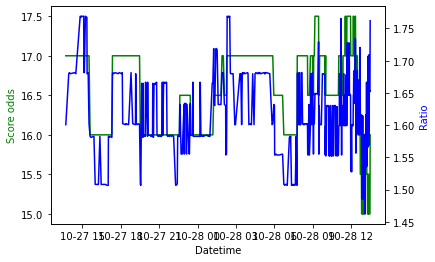

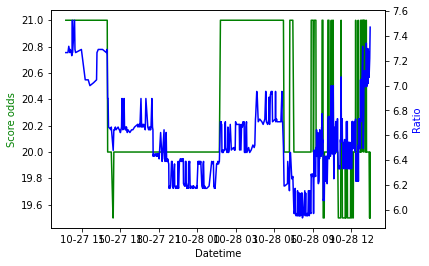

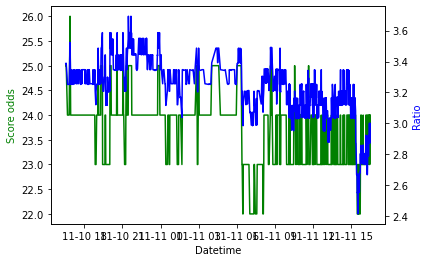

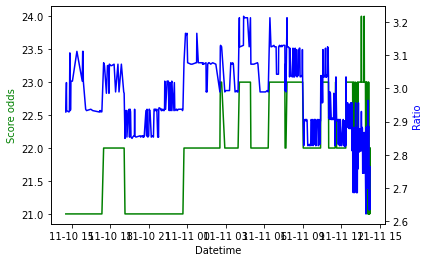

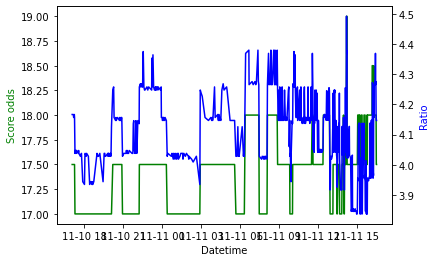

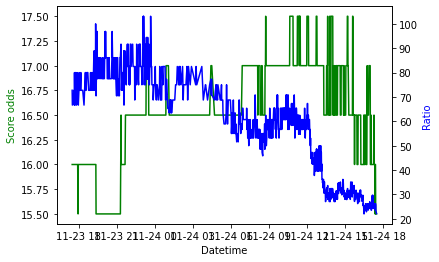

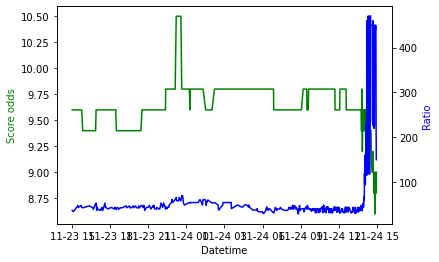

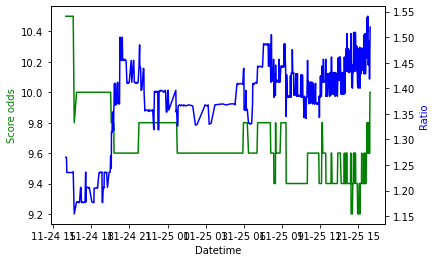

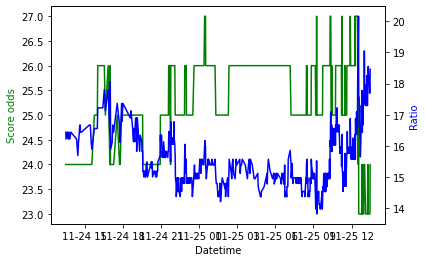

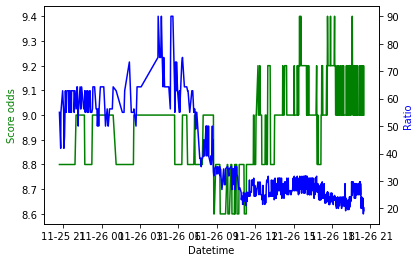

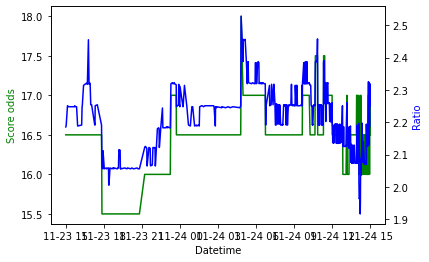

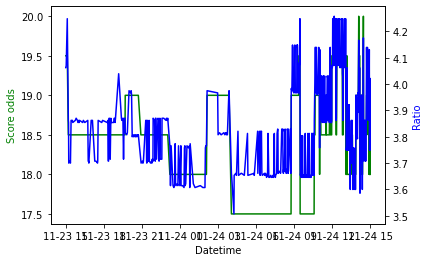

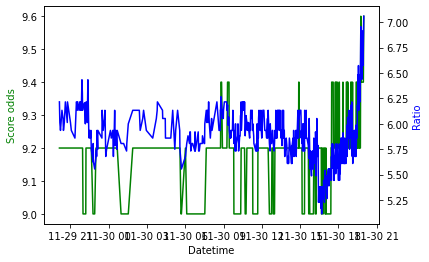

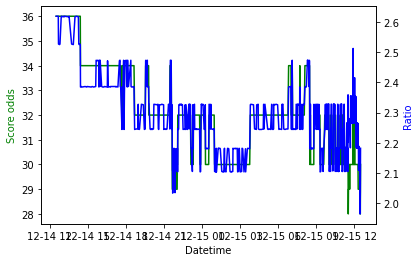

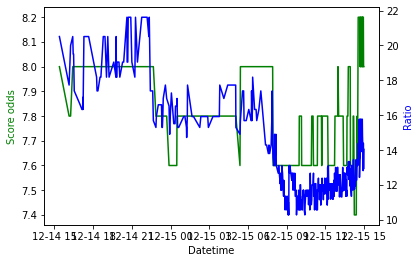

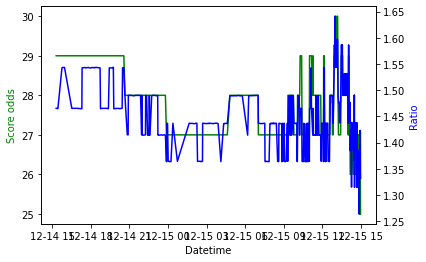

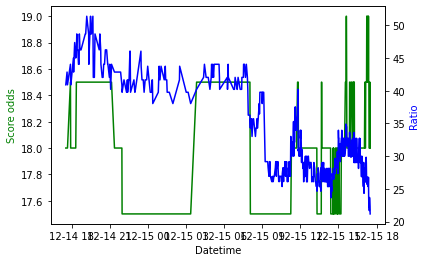

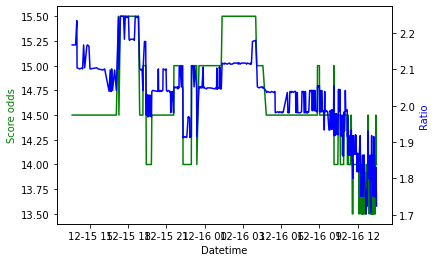

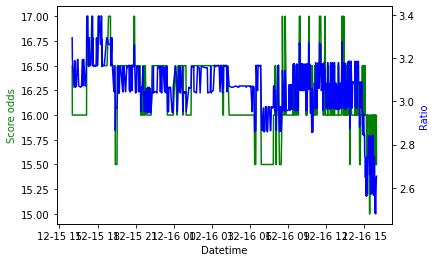

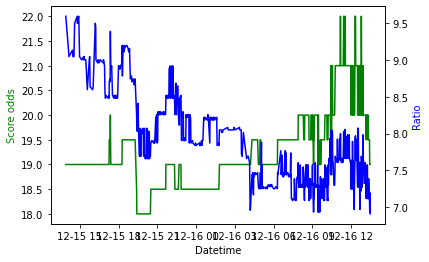

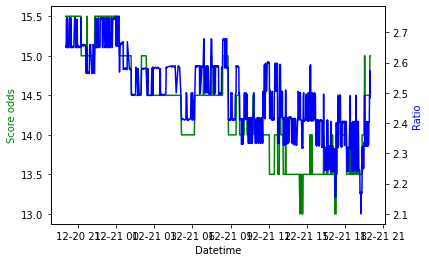

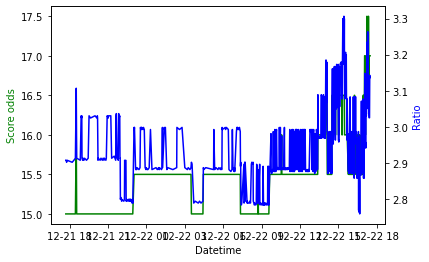

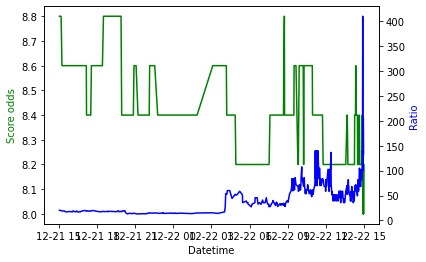

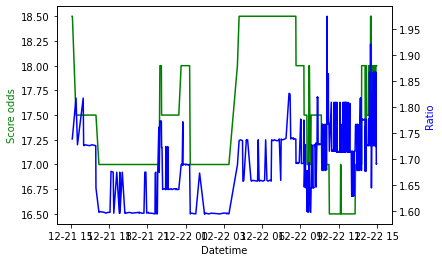

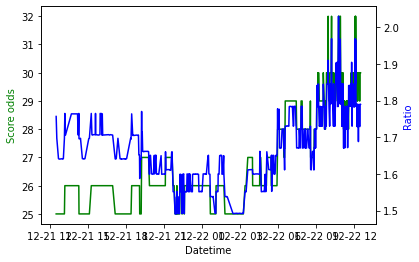

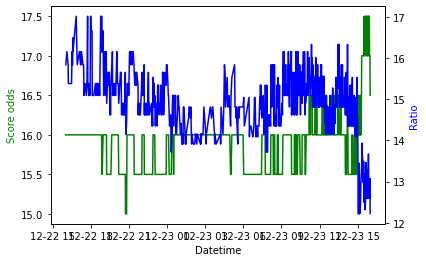

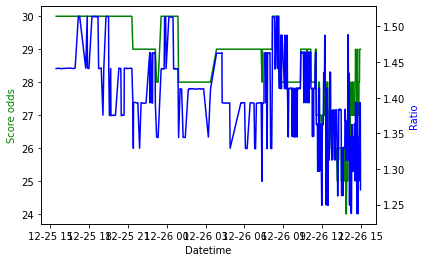

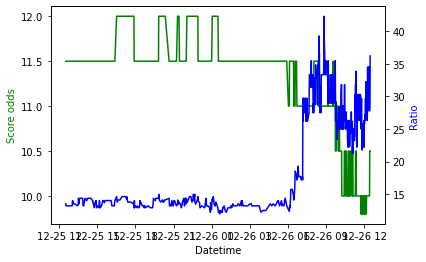

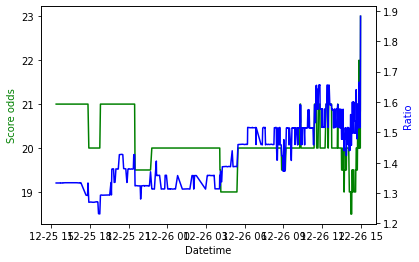

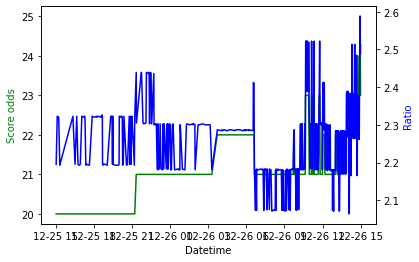

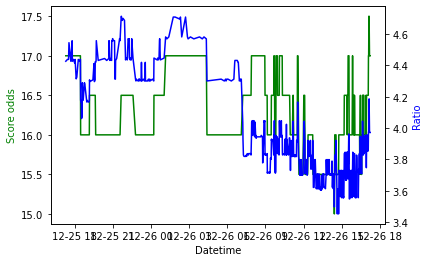

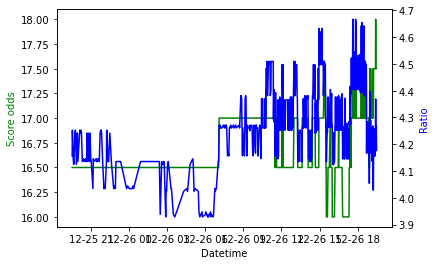

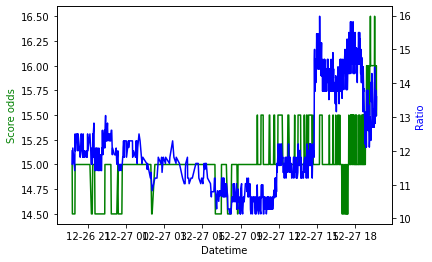

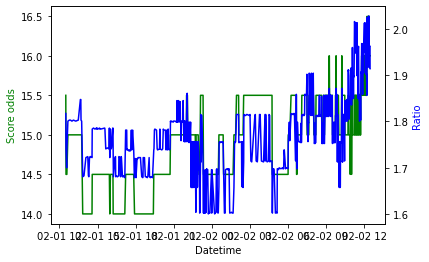

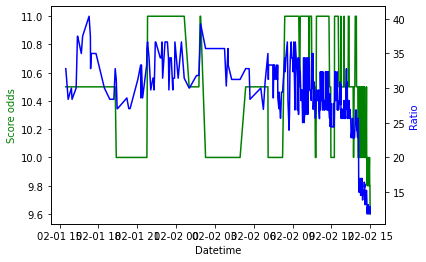

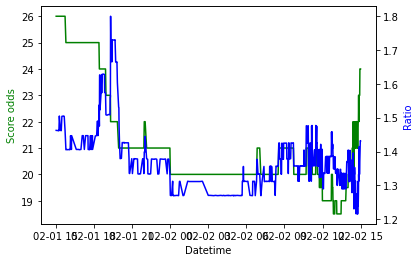

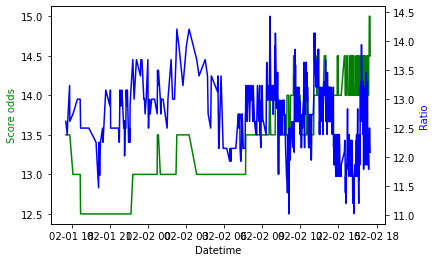

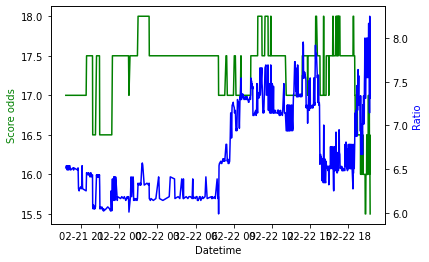

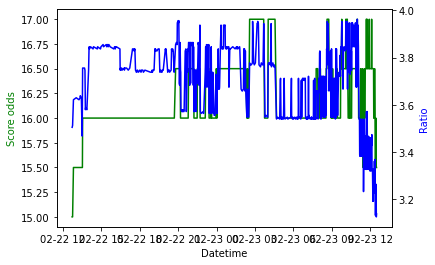

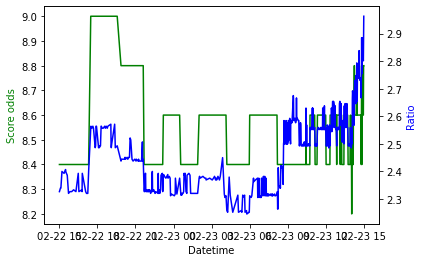

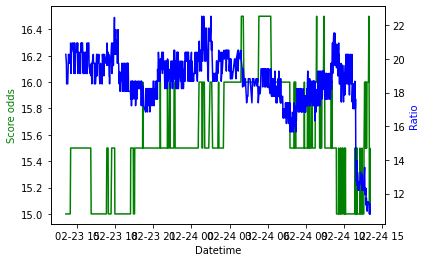

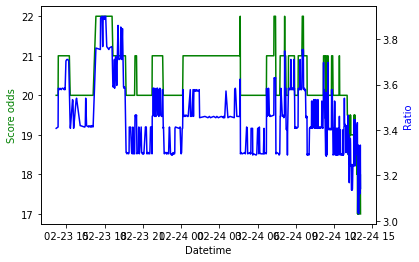

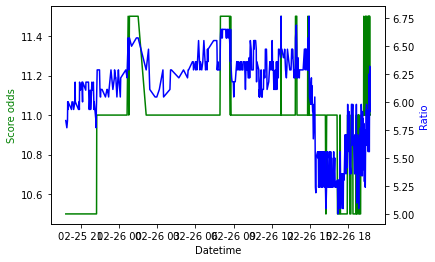

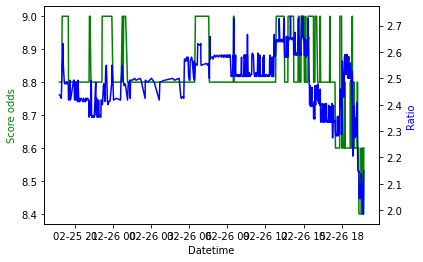

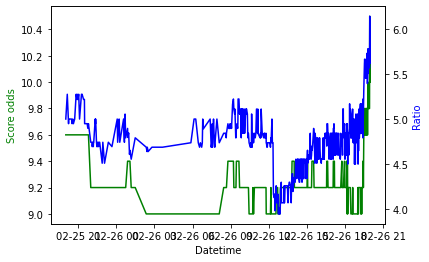

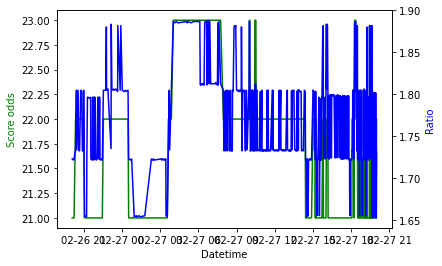

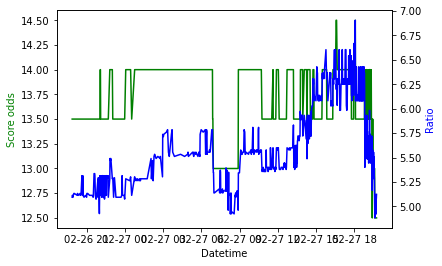

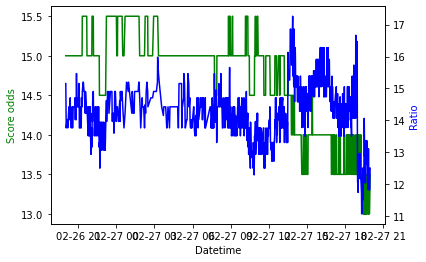

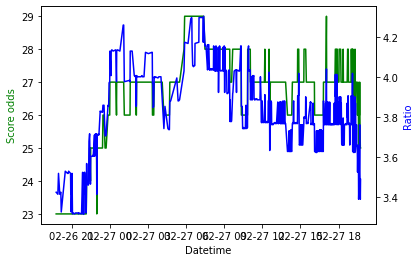

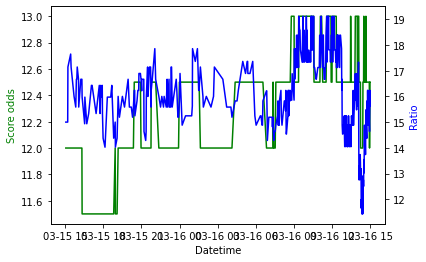

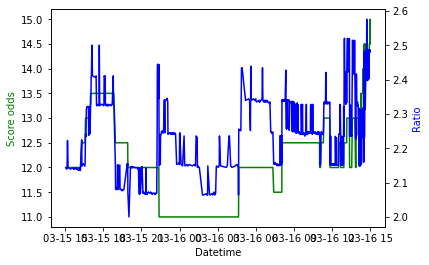

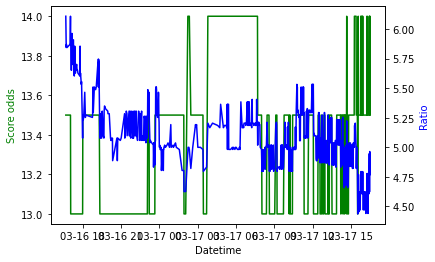

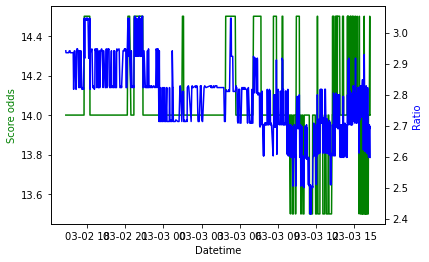

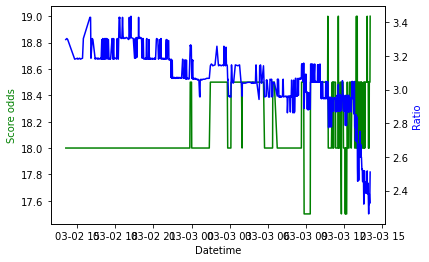

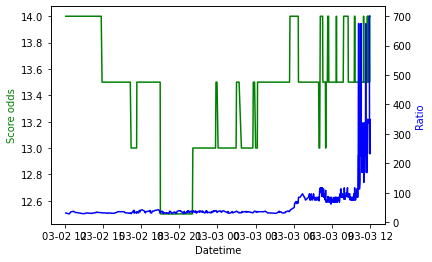

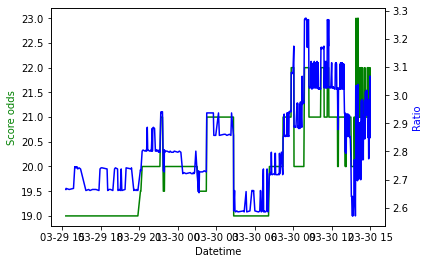

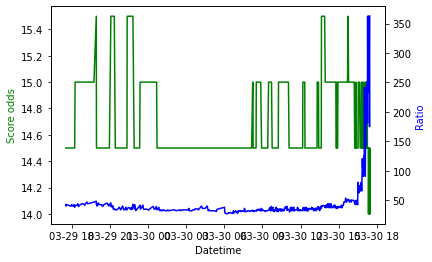

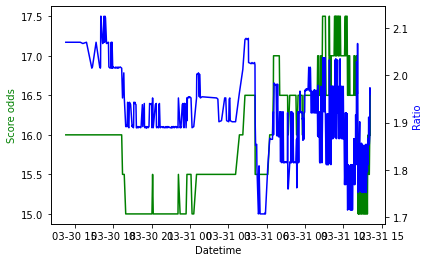

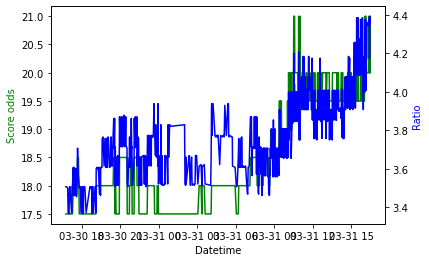

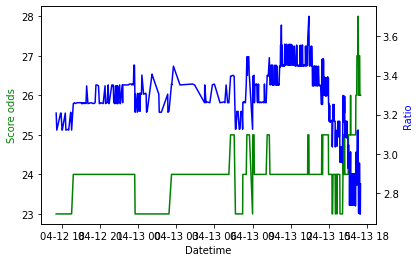

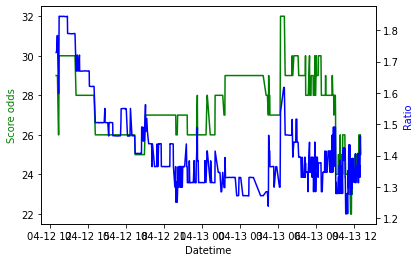

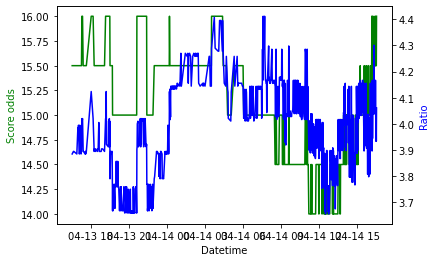

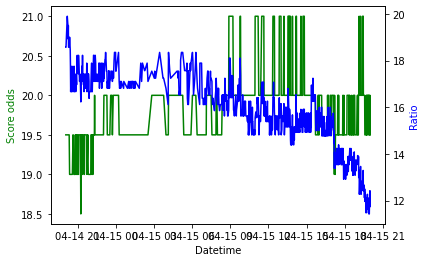

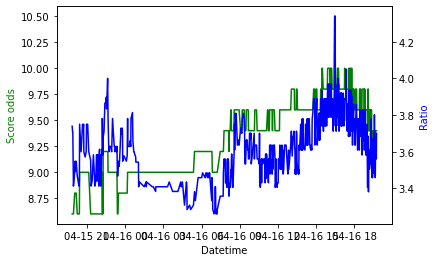

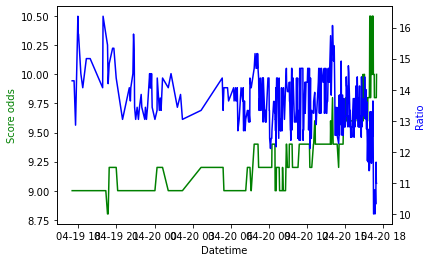

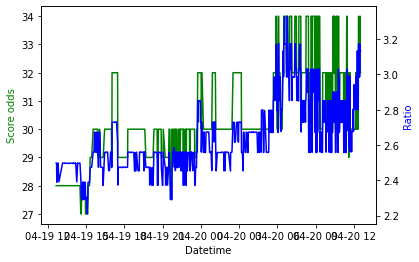

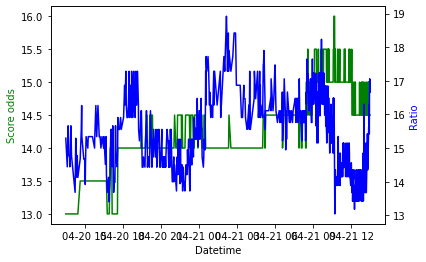

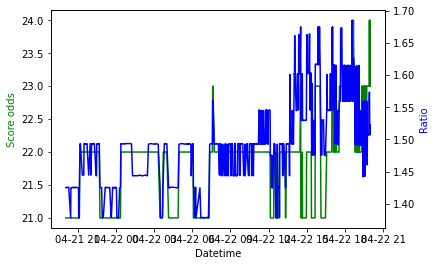

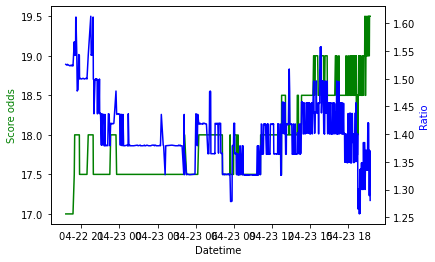

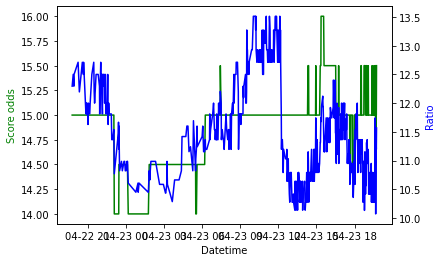

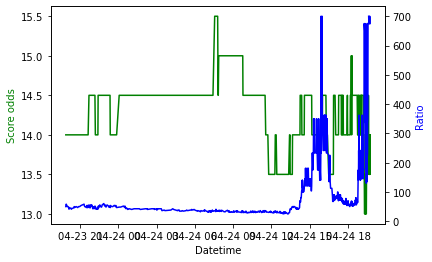

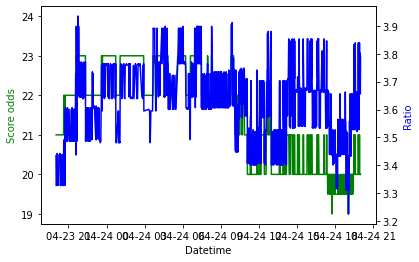

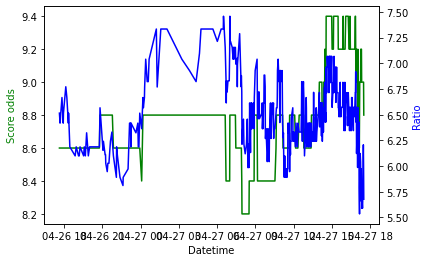

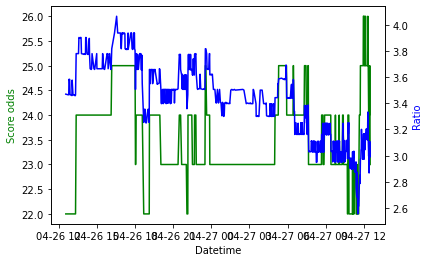

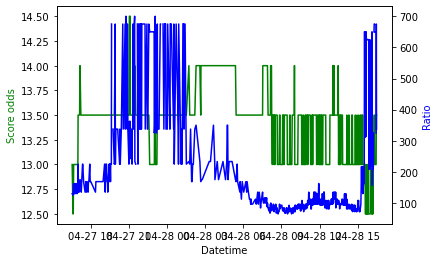

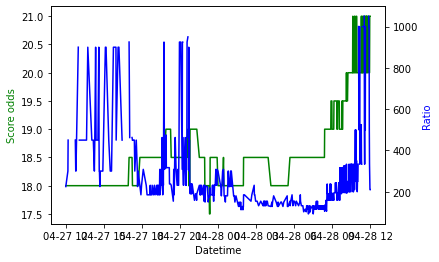

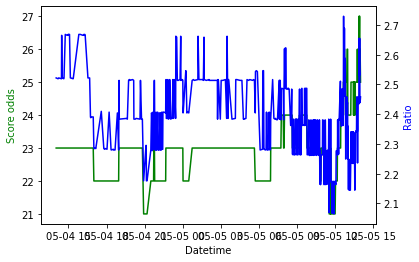

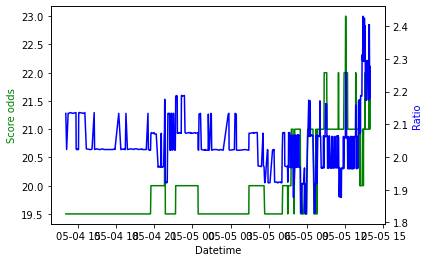

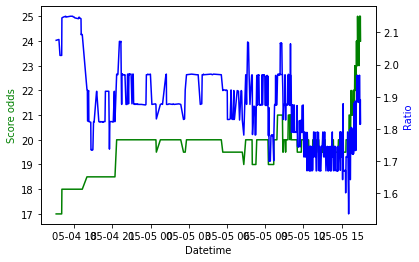

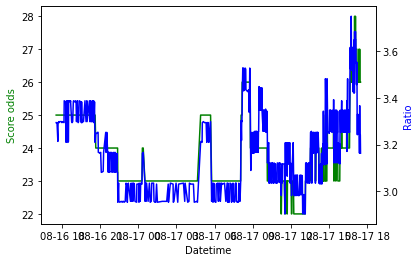

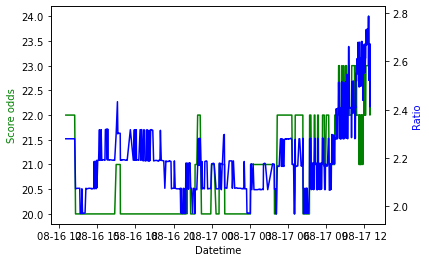

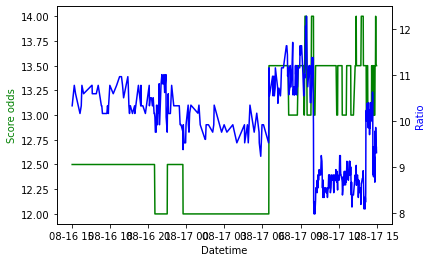

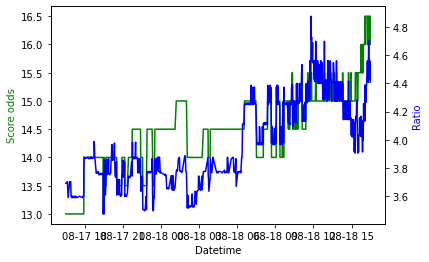

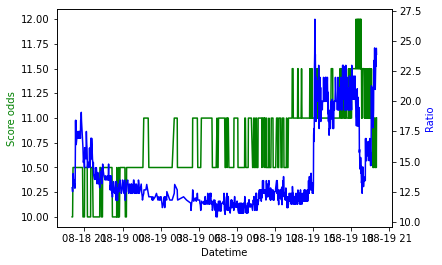

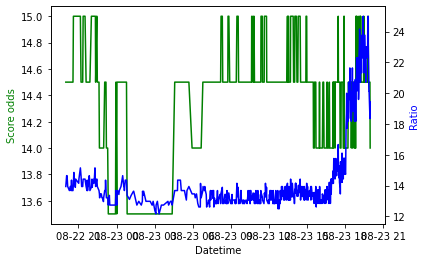

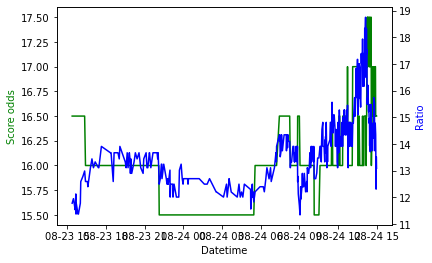

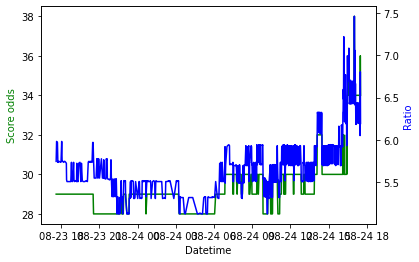

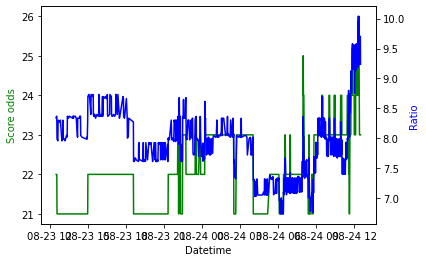

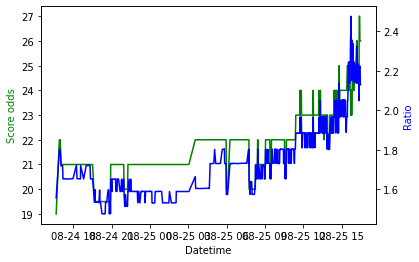

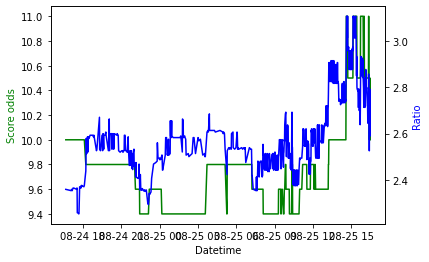

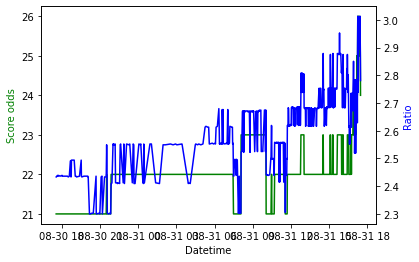

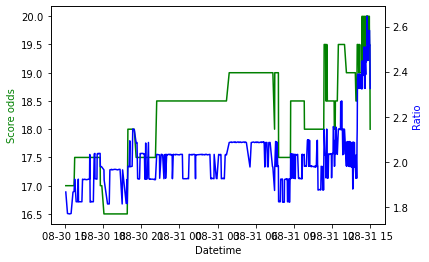

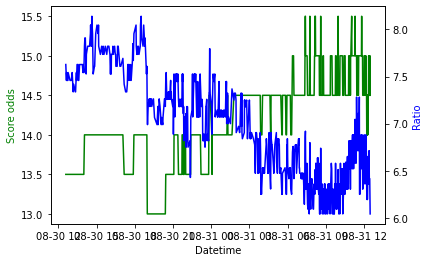

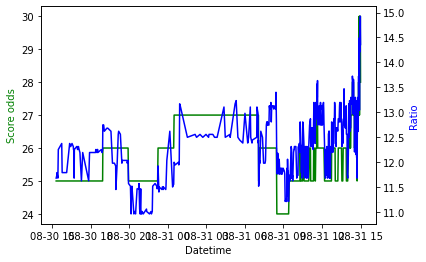

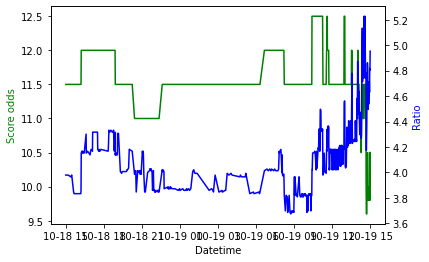

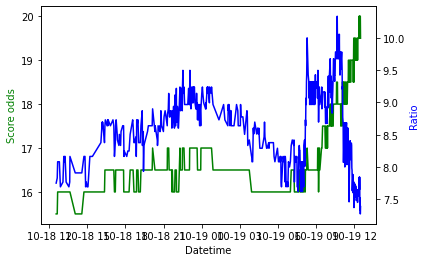

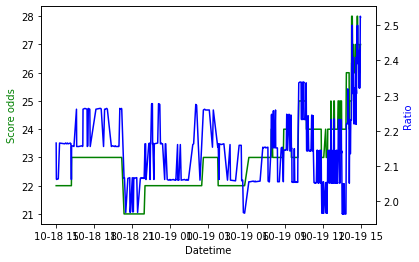

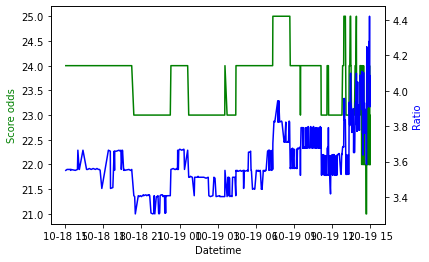

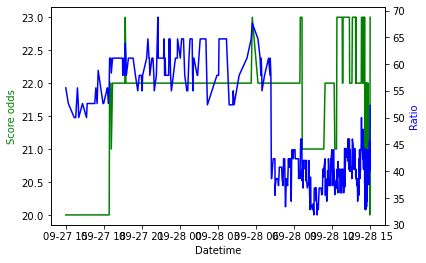

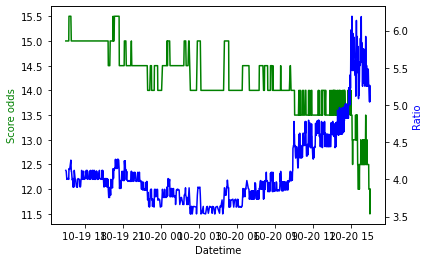

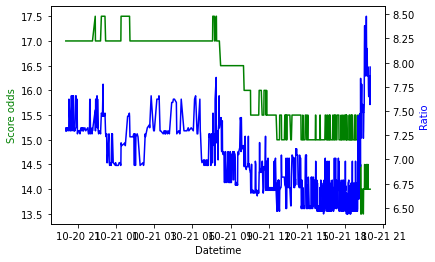

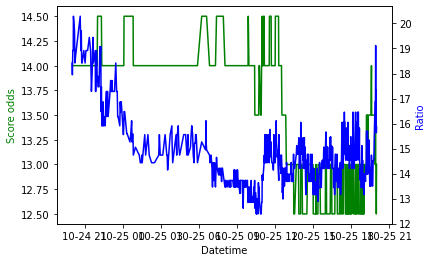

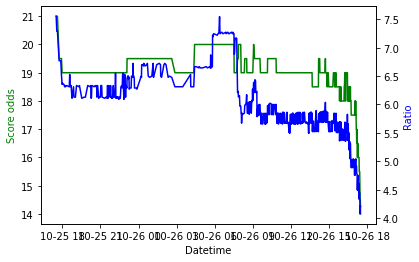

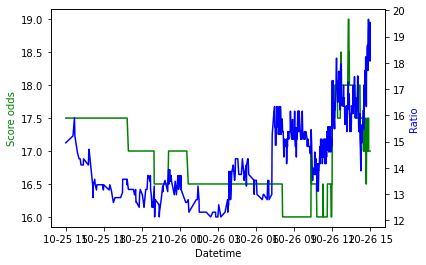

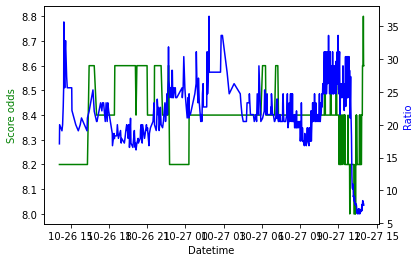

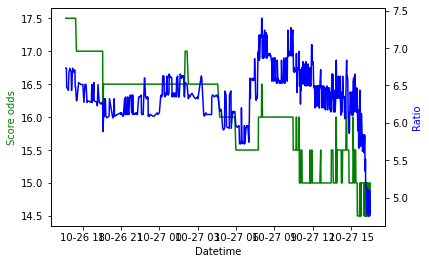

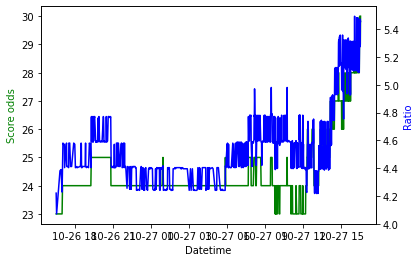

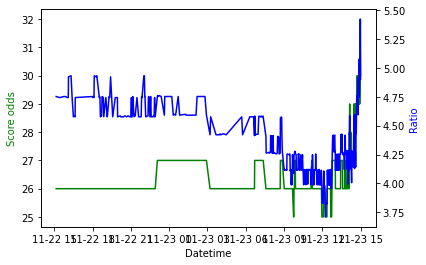

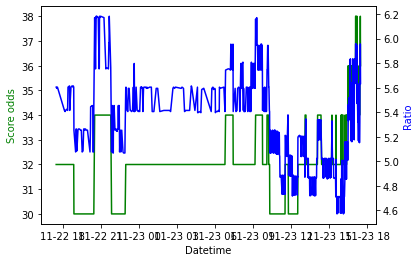

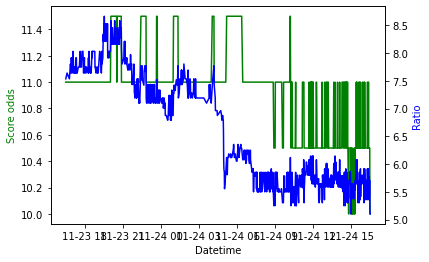

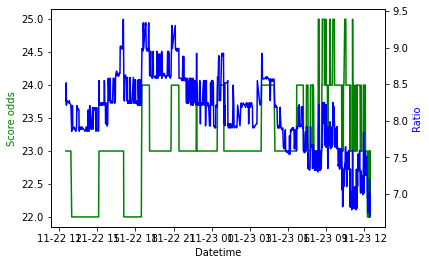

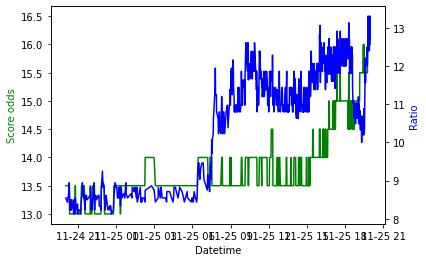

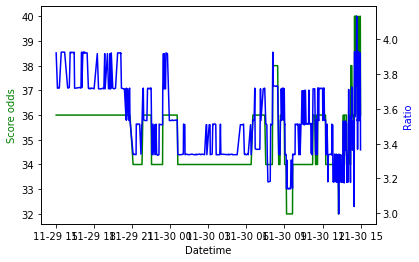

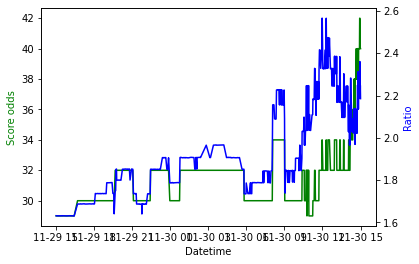

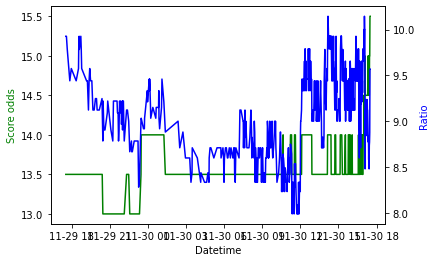

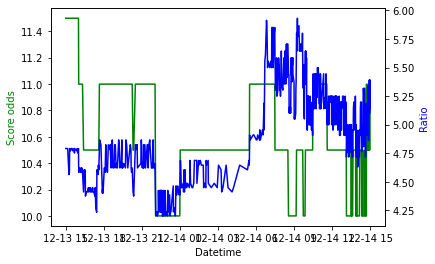

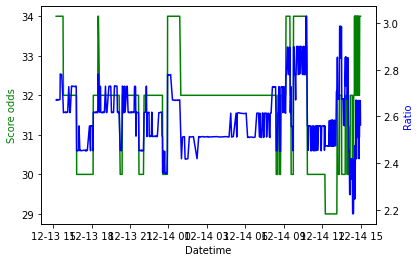

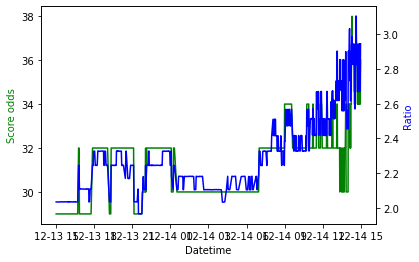

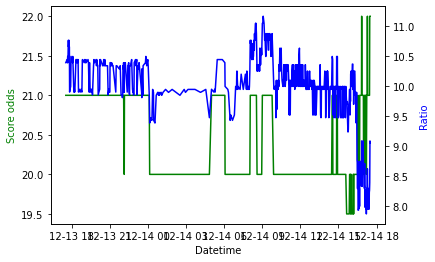

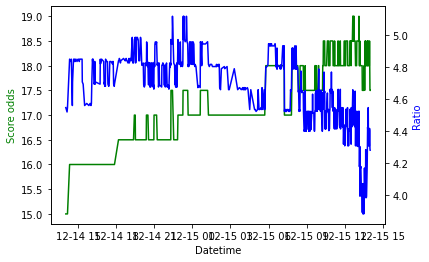

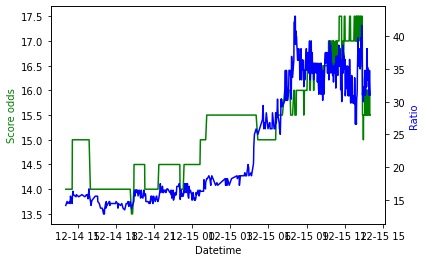

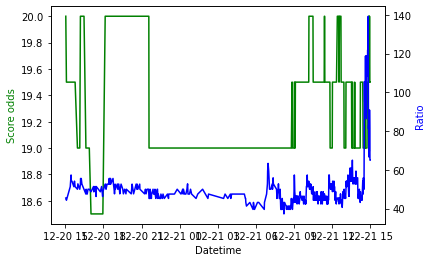

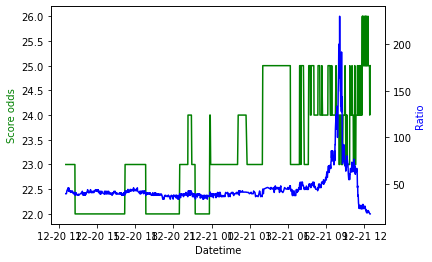

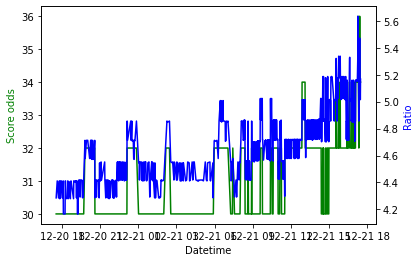

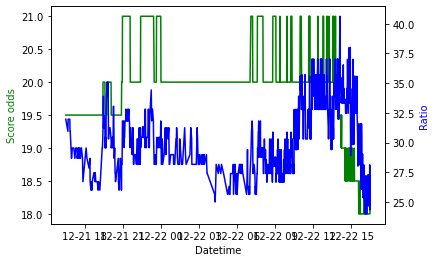

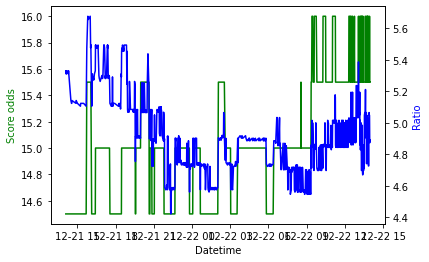

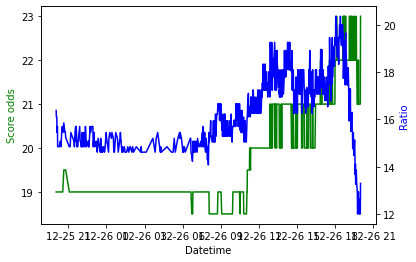

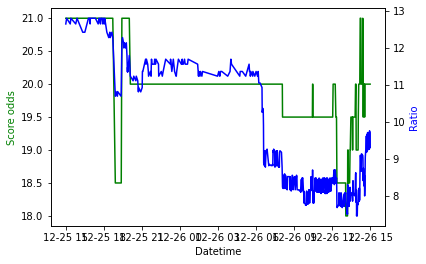

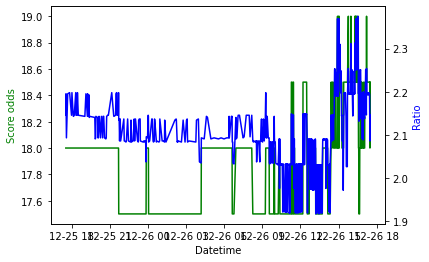

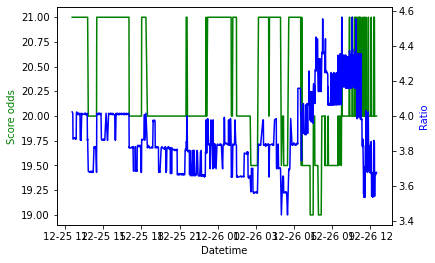

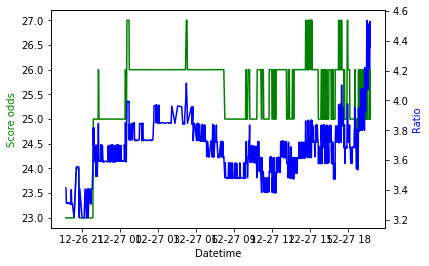

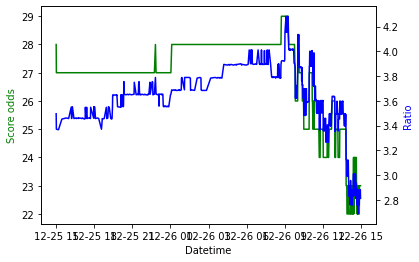

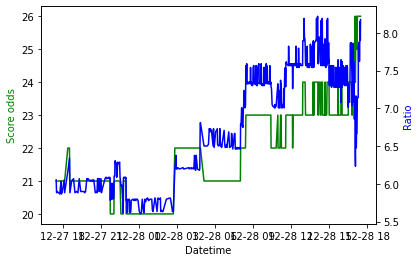

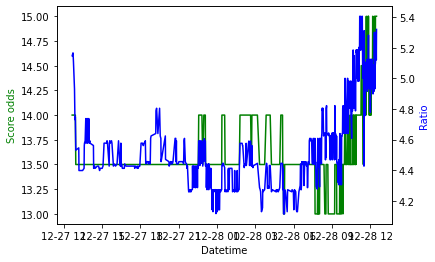

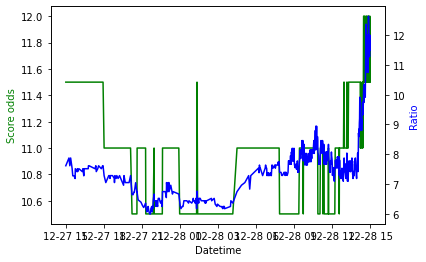

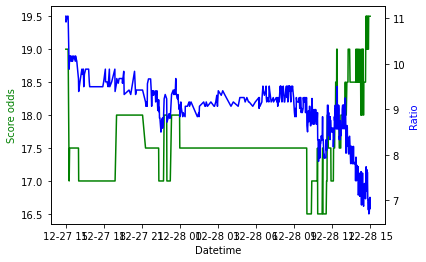

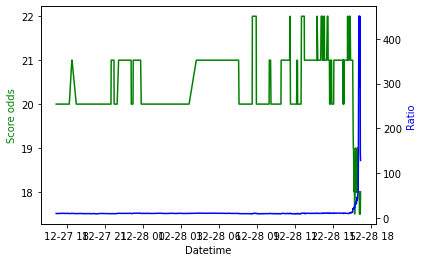

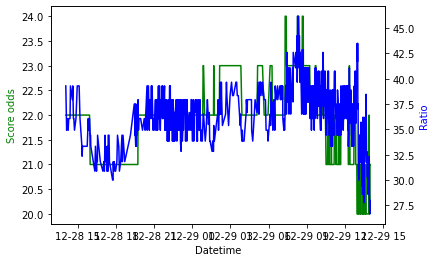

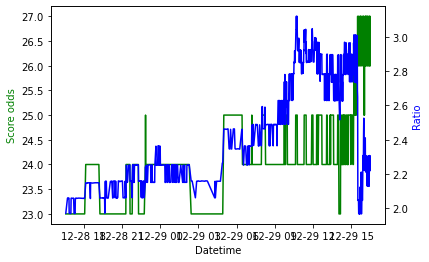

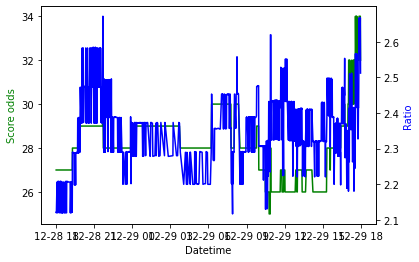

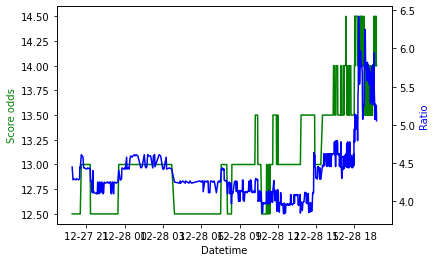

In [17]:
for event_uid in df['event_uid'].unique():
    sub_df = df[df['event_uid'] == event_uid]
    sub_df = sub_df.sort_index(ascending=True)
    start_datetime = last_datetime - relativedelta(days=1)
    sub_df = sub_df[sub_df.index > start_datetime]

    x = np.arange(0, 10, 0.1)
    y1 = 0.05 * x**2
    y2 = -1 *y1

    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(sub_df.index, sub_df['score_odds'], 'g-')
    ax2.plot(sub_df.index, sub_df['ratio'], 'b-')

    ax1.set_xlabel('Datetime')
    ax1.set_ylabel('Score odds', color='g')
    ax2.set_ylabel('Ratio', color='b')

    plt.show()



### Simple strategies for trading 0_0 score odds

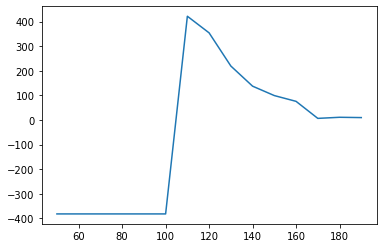

In [14]:
# Test simple high odds grabbing
with dbm.get_managed_session() as session:
    df = get_joined_match_score_odds_df(session)

# Grid search high odds grabbing
profit = []
for odds_percentage in np.arange(50, 200, 10):
    backtest = BacktestStrategy(odds_df=df, initial_bankroll=1000)
    backtest.run_strategy(naive_high_odds_grabber_by_percentage, start_strategy_offset={'days': 4}, 
                          odds_percentage=odds_percentage, back_stake=100, 
                          odds_column_name='score_odds')
    profit.append(backtest.results['profit'])

plt.plot(np.arange(50, 200, 10), profit)